# Wolf-sheep Model

官方的学习的辅助链接：
https://github.com/MARS-Group-HAW/model-wolf-sheep

https://mesa.readthedocs.io/stable/examples/advanced/wolf_sheep.html

https://modelingcommons.org/browse/one_model/1390#model_tabs_browse_info


**Wolf-Sheep Predation Model** 使用 Mesa 模拟了在一个网格环境中，狼（捕食者）和羊（被捕食者）的种群动态。通过简单的规则，我们可以观察到它们的数量如何随着时间和空间互动而波动，甚至出现周期性的涨落。


### 模型目标

- 理解捕食者和被捕食者之间相互依赖的种群动态。
    
- 观察在空间环境中，局部互动如何影响宏观种群趋势。
    
- 学习如何在 Mesa 中处理不同类型的 Agent 和它们的生命周期（出生、死亡、繁殖）


## 🎯 模型概述

### 模型描述
经典的捕食者-被捕食者生态系统模型，模拟狼、羊和草之间的相互作用：
- **羊（Sheep）**：吃草获取能量，能量耗尽死亡，可以繁殖
- **狼（Wolf）**：吃羊获取能量，能量耗尽死亡，可以繁殖
- **草地（Grass）**：被羊吃掉后会自动再生

### 核心机制
- 能量系统：每个智能体都有能量，消耗能量移动，通过进食补充能量
- 繁殖机制：智能体按概率繁殖，能量减半产生后代
- 空间交互：智能体在网格空间中移动，同一格子内的智能体可以交互
- 草地再生：使用倒计时机制实现草地的延迟再生（不使用 ABMSimulator）


## 💡 设计思路

### 1. 分层设计

```
┌─────────────────────────────────┐
│   可视化层 (run.py)            │  ← 用户交互界面
├─────────────────────────────────┤
│   模型层 (model.py)             │  ← 整体控制和协调
├─────────────────────────────────┤
│   智能体层 (agent.py)           │  ← 个体行为实现
├─────────────────────────────────┤
│   基础设施层 (Mesa框架)         │  ← 空间、调度、数据收集
└─────────────────────────────────┘
```


## 📐 模型架构

```
Model (WolfSheep)
├── Grid (OrthogonalVonNeumannGrid)
├── Agents
│   ├── Sheep (Animal)
│   ├── Wolf (Animal)
│   └── GrassPatch (FixedAgent)
└── DataCollector
```

### 2. 继承关系

```
Agent (Mesa基类)
├── CellAgent (可移动的智能体)
│   └── Animal (动物基类)
│       ├── Sheep (羊)
│       └── Wolf (狼)
└── FixedAgent (固定位置的智能体)
    └── GrassPatch (草地)
```


## 背景知识：ABMSimulator（可选）

> **注意**：本教程版本**不使用 ABMSimulator**，而是使用简单的倒计时机制实现草地再生。如果你需要了解 ABMSimulator，可以参考 `2_example_wolf_sheep_model_withABMsimulator` 目录。



## 🚀 快速开始

### 1. 运行模型
```bash
cd mesa_offical
solara run run.py
# 或
python run.py  # 在 Jupyter 中
```

> 下面的代码是 notebook 直接运行即可

# Agent 创建

Mesa 使用基于集合的方法AgentSet，使用户能够高效直观地管理其代理。大多数情况下，用户不会显式调用 AgentSet

#### 2.2 Agent（智能体层）
- **Animal（基类）**：
  - 能量管理
  - 移动行为
  - 繁殖逻辑
  - 死亡判断
- **Sheep（羊）**：
  - 吃草行为
  - 避狼移动
- **Wolf（狼）**：
  - 捕食行为
  - 追羊移动
- **GrassPatch（草地）**：
  - 生长状态管理
  - 倒计时机制实现自动再生（不使用 ABMSimulator）

In [6]:
from mesa.discrete_space import CellAgent, FixedAgent


class Animal(CellAgent):
    """动物基类，封装通用的能量与生命周期逻辑。"""

    def __init__(
        self, model, energy=8, p_reproduce=0.04, energy_from_food=4, cell=None
    ):
        """Initialize an animal.

        Args:
            model: Model instance
            energy: Starting amount of energy
            p_reproduce: Probability of reproduction (asexual)
            energy_from_food: Energy obtained from 1 unit of food
            cell: Cell in which the animal starts
        """
        super().__init__(model)
        self.energy = energy
        self.p_reproduce = p_reproduce
        self.energy_from_food = energy_from_food
        self.cell = cell

    def spawn_offspring(self):
        """创建一个与当前类型相同的后代，并按能量守恒分摊。"""
        self.energy /= 2
        self.__class__(
            self.model,
            self.energy,
            self.p_reproduce,
            self.energy_from_food,
            self.cell,
        )

    def feed(self):
        """抽象方法，由子类实现具体进食逻辑。"""

    def step(self):
        """执行动物的一个行为周期。"""
        # 1. 先移动到邻近网格（具体策略由子类实现）
        self.move()
        # 2. 移动会消耗基础能量
        self.energy -= 1
        # 3. 尝试进食获取能量
        self.feed()
        # 4. 能量耗尽则死亡；否则按概率繁殖
        if self.energy < 0:
            self.remove()
        elif self.random.random() < self.p_reproduce:
            self.spawn_offspring()


class Sheep(Animal):
    """羊：会避开狼、优先寻草的草食动物。"""

    def feed(self):
        """若所在格子存在可食用草地，则摄入能量并触发草地再生倒计时。"""
        grass_patch = next(
            obj for obj in self.cell.agents if isinstance(obj, GrassPatch)
        )
        if grass_patch.fully_grown:
            self.energy += self.energy_from_food
            grass_patch.fully_grown = False

    def move(self):
        """优先移动至安全且有成熟草地的格子。"""
        cells_without_wolves = self.cell.neighborhood.select(
            lambda cell: not any(isinstance(obj, Wolf) for obj in cell.agents)
        )
        if len(cells_without_wolves) == 0:
            return  # 周围全是狼则原地不动，避免送死

        cells_with_grass = cells_without_wolves.select(
            lambda cell: any(
                isinstance(obj, GrassPatch) and obj.fully_grown for obj in cell.agents
            )
        )
        target_cells = (
            cells_with_grass if len(cells_with_grass) > 0 else cells_without_wolves
        )
        self.cell = target_cells.select_random_cell()


class Wolf(Animal):
    """狼：会追逐羊的捕食者。"""

    def feed(self):
        """若当前格子有羊，随机捕食一只并获得能量。"""
        sheep = [obj for obj in self.cell.agents if isinstance(obj, Sheep)]
        if sheep:
            sheep_to_eat = self.random.choice(sheep)
            self.energy += self.energy_from_food
            sheep_to_eat.remove()

    def move(self):
        """优先向有羊的邻居格子移动，以提高捕食概率。"""
        cells_with_sheep = self.cell.neighborhood.select(
            lambda cell: any(isinstance(obj, Sheep) for obj in cell.agents)
        )
        target_cells = (
            cells_with_sheep if len(cells_with_sheep) > 0 else self.cell.neighborhood
        )
        self.cell = target_cells.select_random_cell()


class GrassPatch(FixedAgent):
    """草地：被羊啃食后按固定时间再生的固定型智能体。
    
    本版本使用倒计时机制，不使用 ABMSimulator 的事件调度。
    """

    def __init__(self, model, countdown, grass_regrowth_time, cell):
        """创建草地智能体。

        Args:
            model: 模型实例
            countdown: 距离成熟还需等待的步数
            grass_regrowth_time: 再生所需的总步数
            cell: 所在的网格格子
        """
        super().__init__(model)
        self.grass_regrowth_time = grass_regrowth_time
        self.countdown = countdown  # 倒计时器，在 model.step() 中更新
        self.cell = cell
        self._fully_grown = countdown == 0  # 初始化时根据倒计时决定是否成熟

    @property
    def fully_grown(self):
        """草地是否成熟可食。"""
        return self._fully_grown

    @fully_grown.setter
    def fully_grown(self, value: bool) -> None:
        """设置草地状态：被吃掉时重置倒计时。"""
        self._fully_grown = value
        if not value:
            # 不使用事件调度，改为重置倒计时
            # 在 model.step() 中会检查并更新倒计时
            self.countdown = self.grass_regrowth_time
            
            

ModuleNotFoundError: No module named 'mesa.discrete_space'

#### 2.1 Model（模型层）
- **职责**：管理整个模拟环境
- **功能**：
  - 初始化空间（网格）
  - 创建智能体
  - 定义时间步行为
  - 收集数据

In [ ]:
"""狼-羊捕食模型（Mesa 实现）
================================

本文件复现经典的 NetLogo Wolf-Sheep 模型，并展示 Mesa 3.0 的关键特性：

* 使用 `OrthogonalVonNeumannGrid` 构建环形网格空间。
* 通过倒计时机制实现草地再生（不使用 ABMSimulator）。
* 利用 `agents_by_type` 与 `create_agents` 高效地管理大量智能体。
* 通过 `DataCollector` 自动收集模型级指标，为可视化与分析提供支持。
"""

import math

from mesa import Model
from mesa.datacollection import DataCollector
from mesa.discrete_space import OrthogonalVonNeumannGrid
from agent import GrassPatch, Sheep, Wolf


class WolfSheep(Model):
    """狼-羊-草生态系统模型。

    - `Sheep`：草食动物，会吃草并繁殖。
    - `Wolf`：捕食者，会吃羊并繁殖。
    - `GrassPatch`：草地，被吃掉后若启用草生长，则按倒计时恢复。

    模型展示了能量流转、捕食关系以及环境资源再生的交互效果。
    """

    def __init__(
        self,
        width=20,
        height=20,
        initial_sheep=100,
        initial_wolves=50,
        sheep_reproduce=0.04,
        wolf_reproduce=0.05,
        wolf_gain_from_food=20,
        grass=True,
        grass_regrowth_time=30,
        sheep_gain_from_food=4,
        seed=None,
    ):
        """初始化模型参数并构建环境。

        Args:
            width: 网格宽度。
            height: 网格高度。
            initial_sheep: 初始羊数量。
            initial_wolves: 初始狼数量。
            sheep_reproduce: 羊的每步繁殖概率。
            wolf_reproduce: 狼的每步繁殖概率。
            wolf_gain_from_food: 狼吃掉一只羊获得的能量。
            grass: 是否启用草地生长（若 False，羊将直接获取固定能量）。
            grass_regrowth_time: 草地被吃掉后重新长好的步数。
            sheep_gain_from_food: 羊吃草获得的能量。
            seed: 随机种子，便于复现随机实验。
        """
        super().__init__(seed=seed)
        
        # Initialize model parameters
        self.height = height
        self.width = width
        self.grass = grass
        self.grass_regrowth_time = grass_regrowth_time

        # Create grid using experimental cell space
        self.grid = OrthogonalVonNeumannGrid(
            [self.height, self.width],
            torus=True,
            capacity=math.inf,  # 使用无限容量的格子，以便多智能体共存
            random=self.random,
        )

        # Set up data collection
        model_reporters = {
            "Wolves": lambda m: len(m.agents_by_type[Wolf]),
            "Sheep": lambda m: len(m.agents_by_type[Sheep]),
        }
        
        if grass:
            model_reporters["Grass"] = lambda m: len(
                m.agents_by_type[GrassPatch].select(lambda a: a.fully_grown)
            )

        self.datacollector = DataCollector(model_reporters)

        # Create sheep:
        Sheep.create_agents(
            self,
            initial_sheep,
            energy=self.rng.random((initial_sheep,)) * 2 * sheep_gain_from_food,
            p_reproduce=sheep_reproduce,
            energy_from_food=sheep_gain_from_food,
            cell=self.random.choices(self.grid.all_cells.cells, k=initial_sheep),
        )
        # Create Wolves:
        Wolf.create_agents(
            self,
            initial_wolves,
            energy=self.rng.random((initial_wolves,)) * 2 * wolf_gain_from_food,
            p_reproduce=wolf_reproduce,
            energy_from_food=wolf_gain_from_food,
            cell=self.random.choices(self.grid.all_cells.cells, k=initial_wolves),
        )

        # Create grass patches if enabled
        if grass:
            possibly_fully_grown = [True, False]
            
            for cell in self.grid:
                fully_grown = self.random.choice(possibly_fully_grown)
                countdown = (
                    0 if fully_grown else self.random.randrange(0, grass_regrowth_time)
                )
                GrassPatch(self, countdown, grass_regrowth_time, cell)

        # Collect initial data
        self.running = True
        self.datacollector.collect(self)

    def step(self):
        """执行一个时间步的模型更新。"""
        # 1. 先让羊执行（随机顺序），确保被捕食前有机会移动/吃草
        self.agents_by_type[Sheep].shuffle_do("step")
        # 2. 再执行狼，避免一个时间步内"狼瞬间移动后立刻被吃"之类的不合理情况
        self.agents_by_type[Wolf].shuffle_do("step")
        
        # 3. 更新草地再生倒计时（不使用 ABMSimulator 的事件调度）
        if self.grass:
            for grass_patch in self.agents_by_type[GrassPatch]:
                if not grass_patch.fully_grown:
                    grass_patch.countdown -= 1
                    if grass_patch.countdown <= 0:
                        grass_patch.fully_grown = True

        # 4. 更新观测数据，便于绘制时间序列曲线
        self.datacollector.collect(self)



#### 2.3 Visualization（可视化层）
- **SpaceRenderer**：空间可视化
- **SolaraViz**：交互式可视化界面
- **DataCollector**：数据收集和图表

f:\BaiduSyncdisk-mu\Projects CUG\Project mesa 2025\my_abm_project\.venv\Lib\site-packages\solara\validate_hooks.py:122: UserWarning: f:\BaiduSyncdisk-mu\Projects CUG\Project mesa 2025\my_abm_project\.venv\Lib\site-packages\mesa\visualization\solara_viz.py:399: ComponentsView: `use_state` found despite early return on line 376
To suppress this check, replace the line with:
    current_tab_index, set_current_tab_index = solara.use_state(0)  # noqa: SH101

Make sure you understand the consequences of this, by reading about the rules of hooks at:
    https://solara.dev/documentation/advanced/understanding/rules-of-hooks

  warnings.warn(str(e))


Cannot show ipywidgets in text

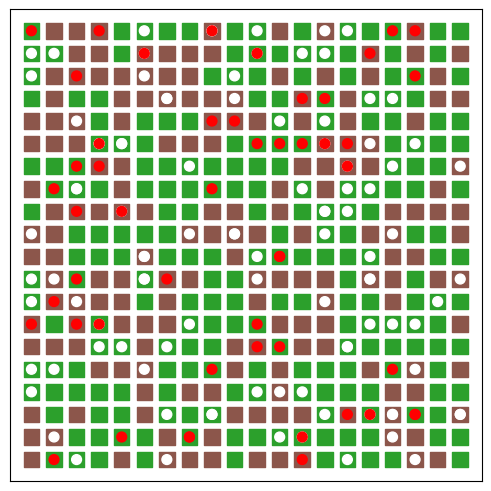

In [ ]:
# 导入模型和智能体（使用本地文件）
from model import WolfSheep
from agent import GrassPatch, Sheep, Wolf

# 导入 Mesa 可视化组件
from mesa.visualization import (
    CommandConsole,
    Slider,
    SolaraViz,
    SpaceRenderer,
    make_plot_component,
)
from mesa.visualization.components import AgentPortrayalStyle


def wolf_sheep_portrayal(agent):
    """定义智能体的可视化样式。
    
    会传入进来多个 agent 对象，需要根据 agent 的类型，返回不同的可视化样式。
    """
    if agent is None:
        return None

    portrayal = AgentPortrayalStyle(size=50, marker="o", zorder=2)

    if isinstance(agent, Wolf):
        portrayal.update(("color", "red"))
    elif isinstance(agent, Sheep):
        portrayal.update(("color", "white"))
    elif isinstance(agent, GrassPatch):
        color = "tab:green" if agent.fully_grown else "tab:brown"
        portrayal.update(("color", color), ("marker", "s"), ("size", 125), ("zorder", 1))

    return portrayal


# 模型参数配置
model_params = {
    "seed": {"type": "InputText", "value": 42, "label": "Random Seed"},
    "grass": {
        "type": "Select",
        "value": True,
        "values": [True, False],
        "label": "Grass regrowth enabled?",
    },
    "grass_regrowth_time": Slider("Grass Regrowth Time", 20, 1, 50),
    "initial_sheep": Slider("Initial Sheep Population", 100, 10, 300),
    "sheep_reproduce": Slider("Sheep Reproduction Rate", 0.04, 0.01, 1.0, 0.01),
    "initial_wolves": Slider("Initial Wolf Population", 10, 5, 100),
    "wolf_reproduce": Slider("Wolf Reproduction Rate", 0.05, 0.01, 1.0, 0.01),
    "wolf_gain_from_food": Slider("Wolf Gain From Food", 20, 1, 50),
    "sheep_gain_from_food": Slider("Sheep Gain From Food", 4, 1, 10),
}


def post_process_space(ax):
    """美化空间视图：设置等比例并移除坐标轴。"""
    ax.set_aspect("equal")
    ax.set_xticks([])
    ax.set_yticks([])


def post_process_lines(ax):
    """美化曲线图：调整图例位置。"""
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.9))


# 创建可视化组件
lineplot_component = make_plot_component(
    {"Wolves": "tab:orange", "Sheep": "tab:cyan", "Grass": "tab:green"},
    post_process=post_process_lines,
)

# 初始化模型（不使用 ABMSimulator）
model = WolfSheep(grass=True)

# 创建空间渲染器
renderer = SpaceRenderer(model, backend="matplotlib")
renderer.draw_agents(wolf_sheep_portrayal)
renderer.post_process = post_process_space

# 创建可视化页面
page = SolaraViz(
    model,
    renderer,
    components=[lineplot_component, CommandConsole],
    model_params=model_params,
    name="Wolf Sheep",
)

page  # noqa

